<a href="https://colab.research.google.com/github/geoffwoollard/prob_prog/blob/main/project/pyro_1D_sigmasignal_shift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
! pip3 install pyro-ppl 

     |████████████████████████████████| 678 kB 8.0 MB/s 


In [88]:
import pyro
import torch
import matplotlib.pyplot as plt
import pyro.distributions as dist
import pandas as pd

def doplt(arr_2d): return plt.imshow(arr_2d, cmap='gray')
pyro.set_rng_seed(101)


# estimating width of atom and shift

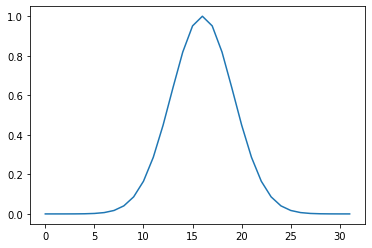

In [496]:
num_pix = 32
domain = torch.arange(-num_pix//2, num_pix//2)
sigma_signal_gt = torch.sqrt(torch.tensor(10.))
clean_signal = torch.exp(-domain**2/(2*sigma_signal_gt**2))
pd.Series(clean_signal).plot()

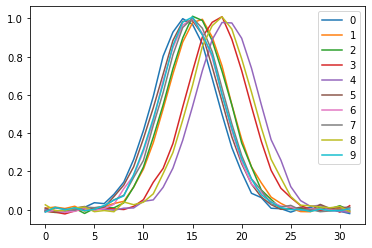

In [571]:
# synthetic data. normally, these would come from actual measurements and we would not know shift. h
# ere we have access to the ground truth
sigma_noise = 0.01
num_particles = 10
data = torch.empty((num_particles,num_pix))
shifts_gt = torch.zeros(num_particles)
for i in range(num_particles):
  shift = dist.Normal(0,2).sample()
  shifts_gt[i] = shift
  clean_signal = torch.exp(-(domain-shift)**2/(2*sigma_signal_gt**2))
  data[i] = dist.Normal(clean_signal,sigma_noise).sample()
pd.DataFrame(data[:10].numpy().T).plot()

In [572]:
def model(data):
  batch_size=1
  shift = 0# pyro.sample('shift',dist.Normal(0,2))
  sigma_signal_mean = pyro.sample('sigma_signal_mean',dist.Normal(torch.tensor(3.1623)-1,1)) # biased model off from ground truth
  sigma_signal_std = pyro.sample('sigma_signal_std',dist.Normal(.1,0.01))
  sigma_signal = pyro.sample('sigma_signal',dist.Normal(sigma_signal_mean,torch.abs(sigma_signal_std)))
  
  for i in pyro.plate("data", size=len(data), subsample_size=batch_size):
    shift = pyro.sample('shift_%i'%i, dist.Normal(0,2))
    clean_signal = torch.exp(-(domain-shift)**2/(2*sigma_signal**2))
    pyro.sample("particle_1d_%i"%i, dist.Normal(clean_signal, sigma_noise).to_event(1), obs=data[i])

def guide(data): # the proposal distribution
  """
  learn the parameters of our modelled encoding of the signal (a 1D atom)
  hard coded fixed noise of 0.1
  """
  sigma_signal_mean_mean = pyro.param("sigma_signal_mean_mean", torch.tensor(3.1623-1),constraint=torch.distributions.constraints.positive) # biased guide (starting from) off from ground truth but matching model
  sigma_signal_mean_std = pyro.param("sigma_signal_mean_std", torch.tensor(1), constraint=torch.distributions.constraints.positive)  
  sigma_signal_std_mean = pyro.param("sigma_signal_std_mean", torch.tensor(0.1),constraint=torch.distributions.constraints.positive)
  sigma_signal_std_std = pyro.param("sigma_signal_std_std", torch.tensor(0.01), constraint=torch.distributions.constraints.positive)
  sigma_signal_mean = pyro.sample("sigma_signal_mean",dist.Normal(sigma_signal_mean_mean,sigma_signal_mean_std))
  sigma_signal_std= pyro.sample("sigma_signal_std",dist.Normal(sigma_signal_std_mean,sigma_signal_std_std))
  pyro.sample("sigma_signal",dist.Normal(sigma_signal_mean,torch.abs(sigma_signal_std)))
  

  for i in range(len(data)):
    shift_mean = pyro.param("shift_mean_%i"%i, torch.tensor(0.))
    shift_std = pyro.param("shift_std_%i"%i, torch.tensor(2.),constraint=torch.distributions.constraints.positive)
    pyro.sample('shift_%i'%i, dist.Normal(shift_mean,shift_std))


In [576]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=model, 
                     guide=guide, 
                     optim=pyro.optim.Adam({"lr": 0.03}), 
                     loss=pyro.infer.Trace_ELBO())

0


/usr/local/lib/python3.7/dist-packages/pyro/util.py:289: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'shift_9', 'shift_0', 'shift_5', 'shift_4', 'shift_8', 'shift_6', 'shift_1', 'shift_3', 'shift_2'}
  guide_vars - aux_vars - model_vars
/usr/local/lib/python3.7/dist-packages/pyro/util.py:289: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'shift_9', 'shift_0', 'shift_5', 'shift_8', 'shift_6', 'shift_1', 'shift_3', 'shift_7', 'shift_2'}
  guide_vars - aux_vars - model_vars
/usr/local/lib/python3.7/dist-packages/pyro/util.py:289: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'shift_9', 'shift_0', 'shift_5', 'shift_4', 'shift_6', 'shift_1', 'shift_3', 'shift_7', 'shift_2'}
  guide_vars - aux_vars - model_vars
/usr/local/lib/python3.7/dist-packages/pyro/util.py:289: UserWarning: Fou

200
400
600
800
1000
1200
1400
1600
1800
sigma_signal_mean_mean =  3.1437530517578125
sigma_signal_mean_std =  0.03322388604283333
sigma_signal_std_mean =  0.019226621836423874
sigma_signal_std_std =  0.0052093639969825745


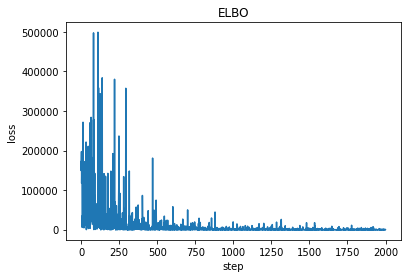

In [577]:
losses, sigma_signal_mean_mean, sigma_signal_mean_std,  sigma_signal_std_mean, sigma_signal_std_std  = [], [], [],[],[]
shift_mean_0  = []
num_epochs = 2000
for ep in range(num_epochs):
    if num_epochs < 10 or (ep%(num_epochs//10) == 0): print(ep)
    losses.append(svi.step(data[:]))
    sigma_signal_mean_mean.append(pyro.param("sigma_signal_mean_mean").item())
    sigma_signal_mean_std.append(pyro.param("sigma_signal_mean_std").item())
    sigma_signal_std_mean.append(pyro.param("sigma_signal_std_mean").item())
    sigma_signal_std_std.append(pyro.param("sigma_signal_std_std").item())
    shift_mean_0.append(pyro.param("shift_mean_0").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('sigma_signal_mean_mean = ',pyro.param("sigma_signal_mean_mean").item())
print('sigma_signal_mean_std = ',pyro.param("sigma_signal_mean_std").item())
print('sigma_signal_std_mean = ',pyro.param("sigma_signal_std_mean").item())
print('sigma_signal_std_std = ',pyro.param("sigma_signal_std_std").item())

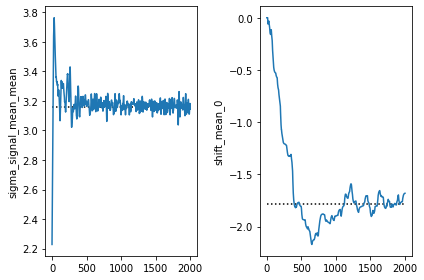

In [581]:
plt.subplot(1,2,1)
plt.plot([0,len(sigma_signal_mean_mean)],[sigma_signal_gt,sigma_signal_gt], 'k:')
plt.plot(sigma_signal_mean_mean)
plt.ylabel('sigma_signal_mean_mean')

plt.subplot(1,2,2)
plt.ylabel('shift_mean_0')
plt.plot([0,len(shift_mean_0)],[shifts_gt[0],shifts_gt[0]], 'k:')
plt.plot(shift_mean_0)

plt.tight_layout()